# Импорт библиотек

In [ ]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from insightface.app import FaceAnalysis

In [ ]:
DATA_PATH = "test_data/images"
ANNOT_PATH = "test_data/annos.json"

# Загрузка и инференс модели

In [ ]:
MODEL_PATH = "opencv_face_detector/opencv_face_detector_uint8.pb"
CONFIG_PATH = "opencv_face_detector/opencv_face_detector.pbtxt"

In [ ]:
# OpenCV DNN
net = cv2.dnn.readNetFromTensorflow(MODEL_PATH, CONFIG_PATH)

# Haar Cascade
haar_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
haar_cascade = cv2.CascadeClassifier(haar_path)

# RetinaFace
app = FaceAnalysis(allowed_modules=['detection'])
app.prepare(ctx_id=0, det_size=(640, 640))

# Вспомогательные функции

In [76]:
def show_image_with_boxes(img: np.ndarray, boxes: list[list[int]],
                          title: str="") -> None:
    """
    Визуализирует изображение с нарисованными bounding boxes.

    Args:
        img (np.ndarray): исходное изображение (BGR формат).
        boxes (list[list[int]]): список боксов в формате [x1, y1, x2, y2].
        title (str): заголовок для изображения (по умолчанию пустая строка).

    Returns:
        None. Показывает изображение с прямоугольниками.
    """
    img_draw = img.copy()
    for (x1, y1, x2, y2) in boxes:
        cv2.rectangle(img_draw, (x1, y1), (x2, y2), (0,255,0), 2)
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def iou(boxA: list[int], boxB: list[int]) -> float:
    """
    Вычисляет метрику Intersection over Union (IoU) между двумя bounding boxes.

    Args:
        boxA (list[int]): бокс в формате [x1, y1, x2, y2].
        boxB (list[int]): бокс в формате [x1, y1, x2, y2].

    Returns:
        float: значение IoU (от 0 до 1).
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def calculate_precision_recall(pred_boxes: list[list[int]], gt_boxes: list[list[int]],
                               iou_threshold: float=0.5) -> tuple[float]:
    """
    Считает precision и recall для одного изображения.

    Args:
        pred_boxes (list[list[int]]): предсказанные боксы в формате [x1, y1, x2, y2].
        gt_boxes (list[list[int]]): ground truth боксы в формате [x1, y1, x2, y2].
        iou_threshold (float): порог для IoU, выше которого предсказание считается true positive.

    Returns:
        tuple:
            precision (float): доля корректно найденных лиц среди всех найденных.
            recall (float): доля найденных лиц среди всех лиц на изображении.
    """
    matched_gt = set()
    tp, fp = 0, 0
    for pb in pred_boxes:
        match_found = False
        for i, gt in enumerate(gt_boxes):
            if i in matched_gt:
                continue
            if iou(pb, gt) >= iou_threshold:
                tp += 1
                matched_gt.add(i)
                match_found = True
                break
        if not match_found:
            fp += 1
    fn = len(gt_boxes) - len(matched_gt)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return precision, recall

def detect_faces_dnn(img: np.ndarray, conf_threshold: float=0.5) -> list[list[int]]:
    """
    Детектирует лица с помощью OpenCV DNN face detector.

    Args:
        img (np.ndarray): исходное изображение (BGR формат).
        conf_threshold (float): порог вероятности (по умолчанию 0.5).

    Returns:
        list[list[int]]: список предсказанных боксов [x1, y1, x2, y2].
    """
    h, w = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), [104, 117, 123], False, False)
    net.setInput(blob)
    detections = net.forward()
    boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * w)
            y1 = int(detections[0, 0, i, 4] * h)
            x2 = int(detections[0, 0, i, 5] * w)
            y2 = int(detections[0, 0, i, 6] * h)
            boxes.append([x1, y1, x2, y2])
    return boxes

def detect_faces_haar(img: np.ndarray) -> list[list[int]]:
    """
    Детекция лиц через Haar Cascade.

    Args:
      img (np.ndarray): исходное изображение

    Returns:
       list[list[int]]: список предсказанных боксов [x1, y1, x2, y2].
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = haar_cascade.detectMultiScale(gray, 1.3, 5)
    boxes = [[x, y, x+w, y+h] for (x,y,w,h) in faces]
    return boxes

def detect_faces_retina(img: np.ndarray, conf_threshold=0.5) -> list[list[int]]:
    """
    Детектирует лица с использованием RetinaFace через FaceAnalysis.

    Args:
        img (np.ndarray): BGR-изображение.
        conf_threshold (float): порог уверенности. По умолчанию 0.5

    Returns:
        list[list[int]]: список боксов [x1, y1, x2, y2].
    """
    faces = app.get(img)  # детектируем
    boxes = []
    for face in faces:
        x1, y1, x2, y2 = face.bbox.astype(int)
        boxes.append([x1, y1, x2, y2])
    return boxes


# Запуск пайплайна

In [82]:
# Функция запуска пайплайна
images_per_method = {"dnn": [], "haar": [], "retina": []}

def run_pipeline(detector_name: str, n_images: int=50) -> dict[str, float]:
    """
    Запускает пайплайн для выбранного метода детекции лиц.

    Args:
        detector_name (str): имя метода ("dnn", "haar", "scrfd").
        n_images (int): количество изображений для теста.

    Returns:
        dict: словарь с итоговыми метриками (precision, recall, время).
    """
    with open(ANNOT_PATH, "r") as f:
        annotations = json.load(f)

    all_precisions, all_recalls, times = [], [], []

    for entry in tqdm(annotations[:n_images]):
        img_path = os.path.join(DATA_PATH, os.path.basename(entry["img_path"]).split("\\")[1])
        img = cv2.imread(img_path)
        if img is None:
            continue

        # GT боксы
        gt_boxes = [[x, y, x+w, y+h] for (x,y,w,h) in entry["annotations"]["bbox"]]

        # Детекция
        start = time.time()
        if detector_name == "dnn":
            pred_boxes = detect_faces_dnn(img)
            precision, recall = calculate_precision_recall(pred_boxes, gt_boxes)
            images_per_method["dnn"].append((img, pred_boxes, precision, recall))
        elif detector_name == "haar":
            pred_boxes = detect_faces_haar(img)
            precision, recall = calculate_precision_recall(pred_boxes, gt_boxes)
            images_per_method["haar"].append((img, pred_boxes, precision, recall))
        elif detector_name == "retina":
            pred_boxes = detect_faces_retina(img)
            precision, recall = calculate_precision_recall(pred_boxes, gt_boxes)
            images_per_method["retina"].append((img, pred_boxes, precision, recall))
        else:
            raise ValueError("Unknown detector")
        end = time.time()

        times.append(end - start)
        all_precisions.append(precision)
        all_recalls.append(recall)

    return {
        "precision": np.mean(all_precisions),
        "recall": np.mean(all_recalls),
        "time": np.mean(times)
    }

# Запуск трёх пайплайнов
results = {}
for method in ["dnn", "haar", "retina"]:
    print(f"\nRunning {method.upper()} detector...")
    results[method] = run_pipeline(method, 500)

# Сравнительный отчет
print("\n=== Итоговый сравнительный отчет ===")
print(f"{'Method':<10} | {'Precision':<10} | {'Recall':<10} | {'Avg Time (s)':<12}")
print("-"*50)
for method, metrics in results.items():
    print(f"{method:<10} | {metrics['precision']:.4f}    | {metrics['recall']:.4f}    | {metrics['time']:.4f}")


Running DNN detector...


100%|██████████| 500/500 [00:34<00:00, 14.65it/s]



Running HAAR detector...


100%|██████████| 500/500 [02:26<00:00,  3.41it/s]



Running RETINA detector...


100%|██████████| 500/500 [03:42<00:00,  2.24it/s]


=== Итоговый сравнительный отчет ===
Method     | Precision  | Recall     | Avg Time (s)
--------------------------------------------------
dnn        | 0.5632    | 0.4391    | 0.0536
haar       | 0.4281    | 0.2770    | 0.2752
retina     | 0.9563    | 0.8226    | 0.4318


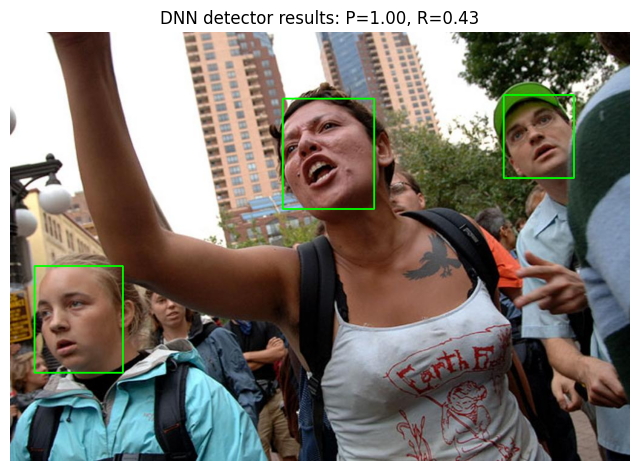

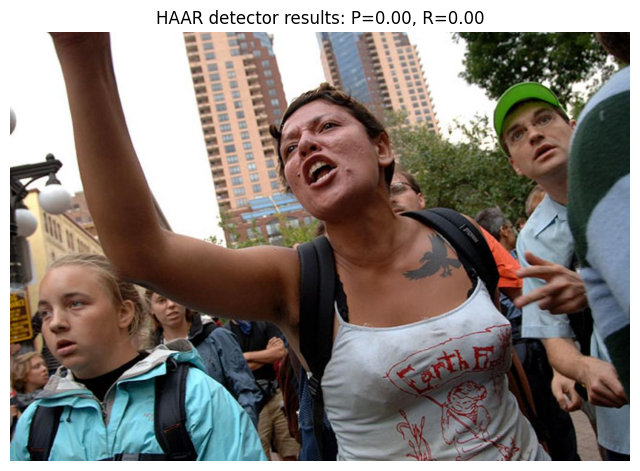

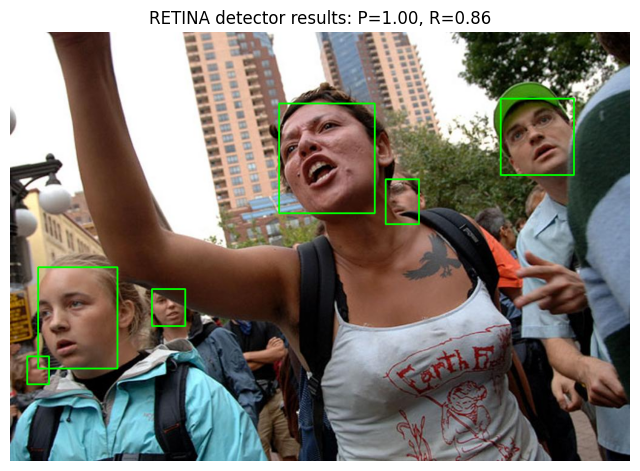

In [83]:
for method in ["dnn", "haar", "retina"]:
    img = images_per_method[method][0][0]
    pred_boxes = images_per_method[method][0][1]
    precision = images_per_method[method][0][2]
    recall = images_per_method[method][0][3]
    show_image_with_boxes(img, pred_boxes, title=f"{method.upper()} detector results: P={precision:.2f}, R={recall:.2f}")